# **Customer Churn Prediction**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE
import shap
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/DATASETS/Churn_Modelling.csv')
df.info()
df.shape

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


(10000, 14)

In [3]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [4]:
# Label Encoding for Gender
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])

# One-Hot Encoding for Geography
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)

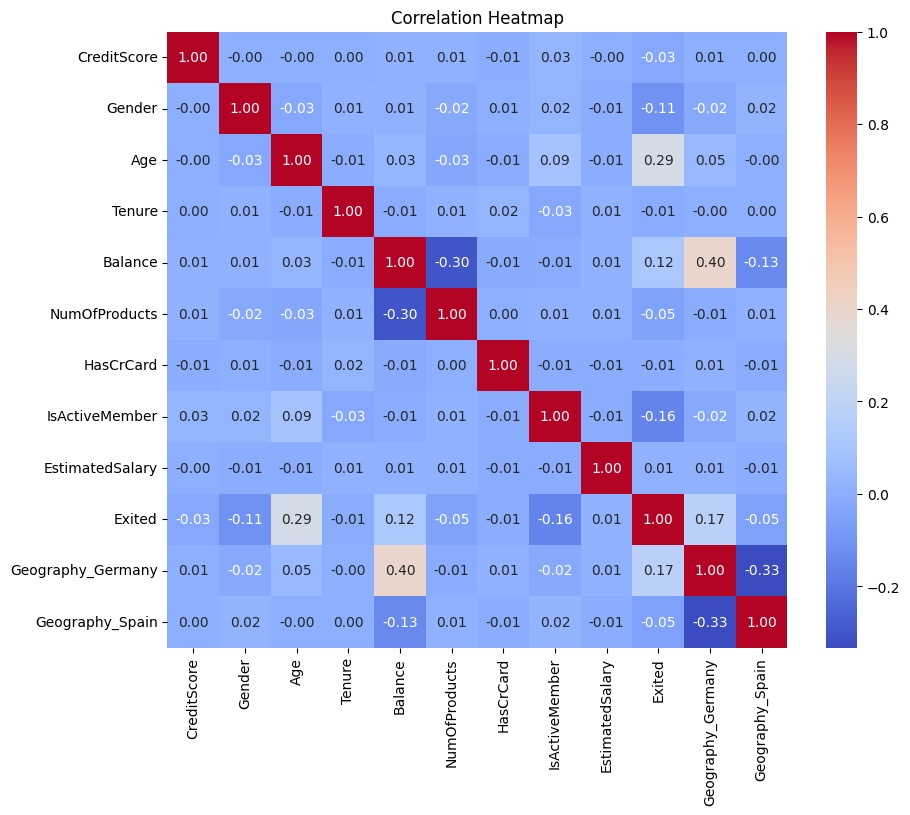

In [5]:
#Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

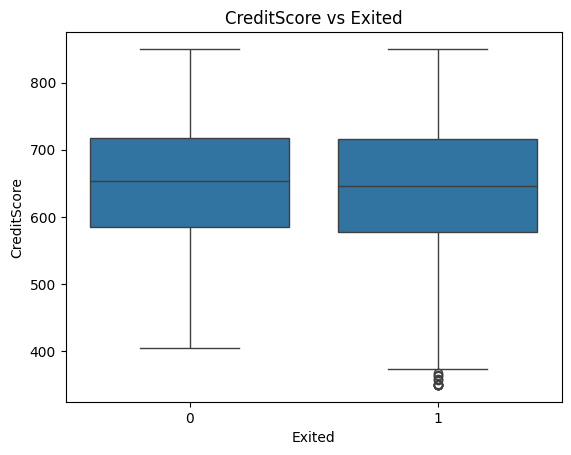

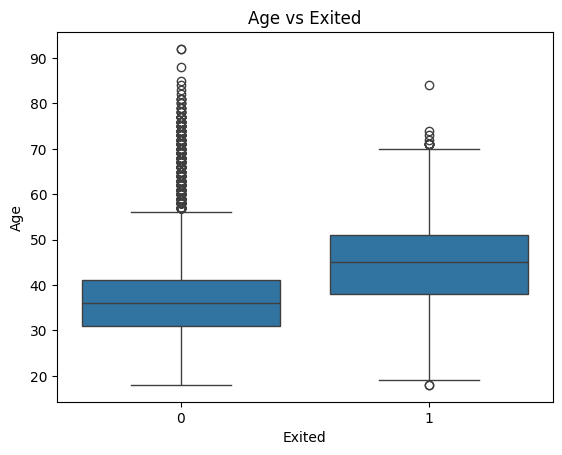

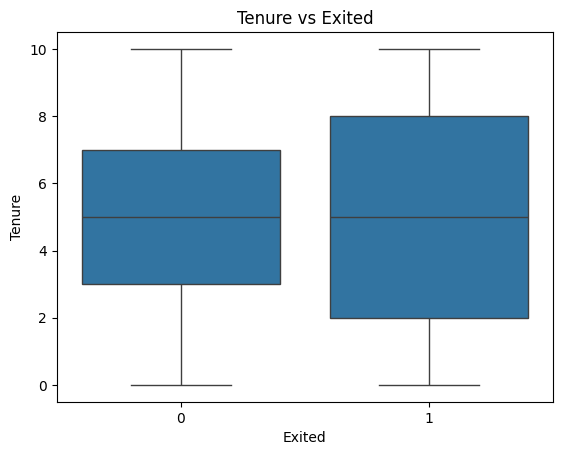

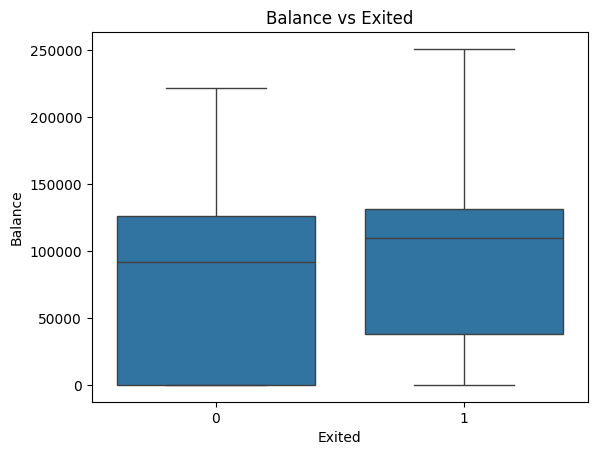

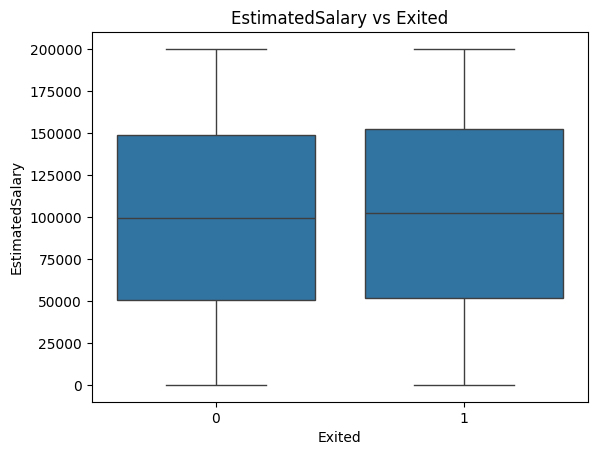

In [6]:
#Boxplots for numeric features
num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
for col in num_cols:
    plt.figure()
    sns.boxplot(x='Exited', y=col, data=df)
    plt.title(f'{col} vs Exited')
    plt.show()

In [7]:
# Split features and label
X = df.drop('Exited', axis=1)
y = df['Exited']

In [8]:
# SMOTE for balancing classes
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [9]:
# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)

In [ ]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_res, test_size=0.2, random_state=42)

# Model + Hyperparameter tuning
rfc = RandomForestClassifier(random_state=42)
params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'criterion': ['sqrt','entropy']
}
grid = GridSearchCV(rfc, params, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

In [11]:
# Cross-validation accuracy
cv_score = cross_val_score(best_model, X_train, y_train, cv=5).mean()
print(f"Cross-Validation Accuracy: {cv_score:.2f}")

Cross-Validation Accuracy: 0.87


In [12]:
# Predictions
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:,1]

In [13]:
# Evaluation Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8763339610797238
ROC AUC Score: 0.9443743003388341

Confusion Matrix:
 [[1433  200]
 [ 194 1359]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      1633
           1       0.87      0.88      0.87      1553

    accuracy                           0.88      3186
   macro avg       0.88      0.88      0.88      3186
weighted avg       0.88      0.88      0.88      3186



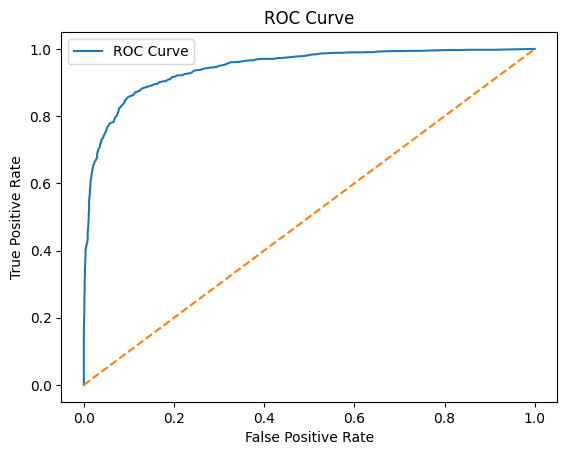

In [14]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

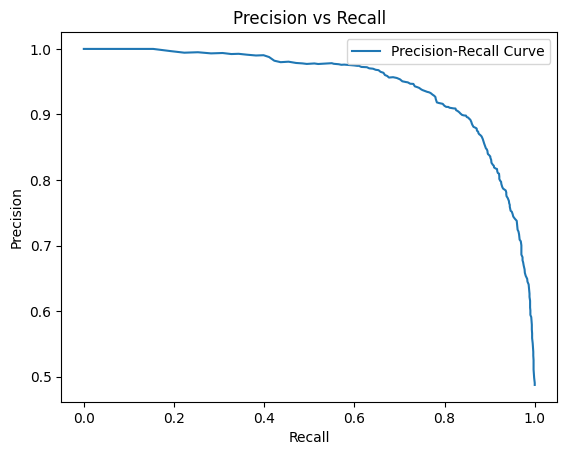

In [15]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure()
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall")
plt.legend()
plt.show()

In [ ]:
# SHAP for Explainability
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values[1], X, plot_type="bar")
shap.summary_plot(shap_values[1], X)

In [ ]:
# Feature Importances
feat_importances = pd.Series(best_model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', title='Top 10 Feature Importances')
plt.show()